In [1]:
%pylab inline
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [2]:
import networkx as nx
import pycombo

## I. Running `pycombo` on a Graph

Unweighted non-directed graph

In [3]:
G = nx.karate_club_graph()

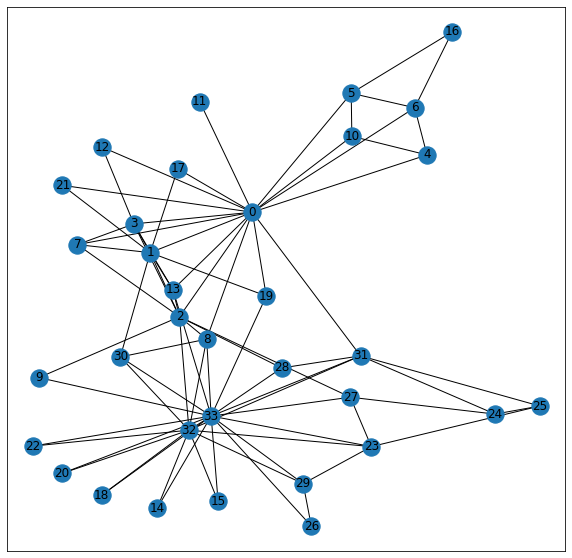

In [5]:
fig, ax =  plt.subplots(figsize=(10,10))

pos=nx.spring_layout(G, seed=42)
nx.draw_networkx(G,pos, ax=ax)

In [28]:
partition, modularity = pycombo.execute(G, return_modularity=True, random_seed=42)

In [29]:
print(f'Partition modularity: {modularity:.5f}')

Partition modularity: 0.41979


# II. Visualize

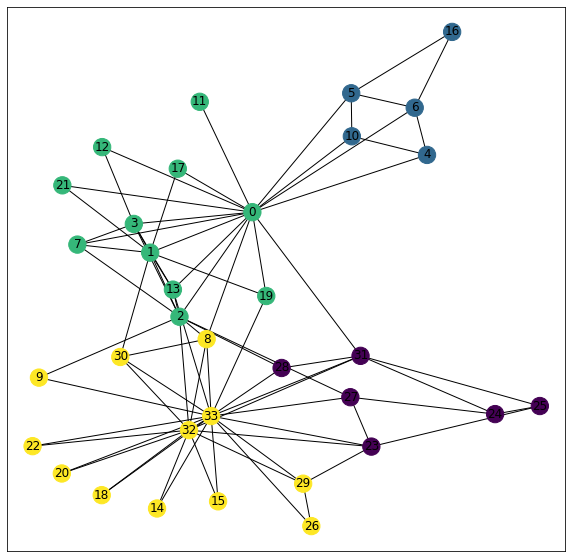

In [36]:
fig, ax =  plt.subplots(figsize=(10,10))

nx.draw_networkx(G, pos, ax=ax, node_color=list(partition.values()));

## III. Execute from file

In [38]:
path = './karate.net'
nx.write_pajek(G, path)

In [39]:
partition, modularity = pycombo.execute(path, return_modularity=True, random_seed=42)

In [40]:
print(f'Partition modularity: {modularity:.5f}')

Partition modularity: 0.41979


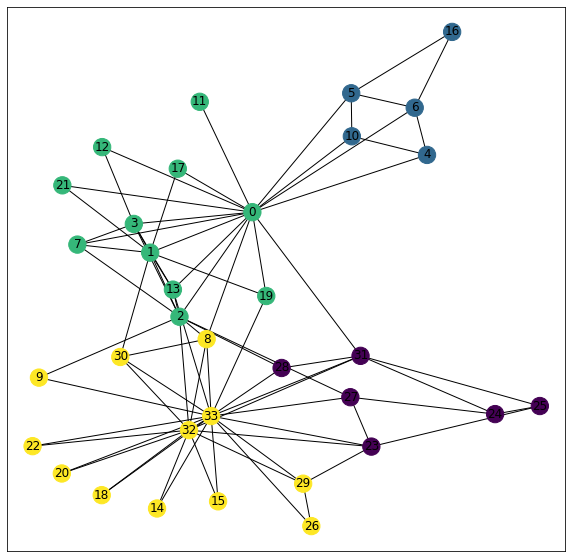

In [41]:
fig, ax =  plt.subplots(figsize=(10,10))

nx.draw_networkx(G, pos, ax=ax, node_color=list(partition.values()));

Let's remove file now:

In [54]:
! rm karate.net

## IV. Execute from adjacency matrix

Our module does not support sparce/dense matrix input right now - but it's easy to construct
a graph from one and pass into the combo.

You can use one of:
- `nx.from_scipy_sparce_matrix`
- `nx.from_numpy_matrix`

In [51]:
sparce_matrix = nx.adjacency_matrix(G)

### A. Sparce

In [49]:
G_from_sparce = nx.from_scipy_sparse_matrix(sparce_matrix)

In [52]:
partition, modularity = pycombo.execute(G_from_sparce, return_modularity=True, random_seed=42)
print(f'Partition modularity: {modularity:.5f}')

Partition modularity: 0.41979


### B. Dense

In [53]:
G_from_dense = nx.from_numpy_matrix(adjacency_matrix.todense())
partition, modularity = pycombo.execute(G_from_dense, return_modularity=True, random_seed=42)
print(f'Partition modularity: {modularity:.5f}')

Partition modularity: 0.41979


# V. Weighted Graph